# Analyzing UK Greenhouse Gas Emissions: A Data Science Approach to Sustainability
### Yeni Jung

**Table of Contents**

1. Data Selection
2. Data Preparation and Exploration with Visualisations
3. Data Analysis with Visualisations
4. Summary Data Visualisation
5. Conclusions and Recommendations
6. Methodology Explanation and Documentation

## Dataset Selection

The dataset selected for this project is **'2005 to 2022 local authority greenhouse gas emissions dataset'**, published by 'Department for Energy Security and Net Zero'. This project used the csv file that can be accessed via the government website *(UK greenhouse gas emissions: local authority and regional - data.gov.uk, 2024)*, lastly updated on 27th June 2024. It provides information on greenhouse gas (GHG) emissions in various regions and sectors across the UK.

**1. Feature description**

This dataset has 15 features:
- Country: UK country name
- Country Code
- Region: UK region name
- Region Code
- Second Tier Authority
- Local Authority
- Local Authority Code
- Calendar Year
- LA GHG Sector: local authority greenhouse gas sector
- LA GHG Sub-sector: local authority greenhouse gas sub-sector
- Greenhouse Gas: type of greenhouse gas
- Territorial emissions (kt CO2e): regional total greenhouse gas emissions
- CO2 emissions within the scope of influence of LAs (kt CO2)
- Mid-year Population (thousands)
- Area (km2)

**2. Justification**

The selected dataset provides a detailed view of UK local authority greenhouse gas emissions, broken down by sector, region, and year. The segmentation of the data is suitable for analysis of temporal trends and regional differences, and provides insight into the main drivers of emissions. The dataset works well with tools like Pandas and NumPy to facilitate statistical analysis and visualisation to support data-driven policy making. Given its recent updates and relevance to sustainability discussions, it is an ideal choice for exploring emissions trends and informing climate action strategies.

## Data Preparation and Exploration
In this section, the dataset is prepared and explored to ensure it is clean, consistent, and ready for analysis. This involves importing the data, addressing missing values and outliers, and performing exploratory data analysis (EDA) to understand distributions, relationships, and patterns using Pandas and Numpy. Key findings are documented to guide further analysis.

### Data Import and Cleaning
In this section, the dataset is imported and if needed, cleaned by addressing missing values, outliers, and inconsistencies using Pandas and Numpy to prepare it for analysis.

**1. Data Import**

To avoid the error in the jupyter notebook, the pre-uploaded google drive is used for import.

In [ ]:
import pandas as pd
import numpy as np

# import dataset
url="https://drive.google.com/file/d/1W5qXuyAChGQKmwRYWdzmtFQ9Wg4gRhOA/view?usp=share_link"
path='https://drive.google.com/uc?id='+url.split('/')[-2]
data = pd.read_csv(path)

**2. Data Cleaning**

Before performing cleaning, the shape (number of records and features) of the dataset and the data type of each column is addressed.

In [ ]:
# the number of records
print(data.shape)   #(533016, 15)

# data type of each column
print(data.dtypes)

**i. Missing Values**

To begin with, the dataset is checked if there is any missing values by ```isnull().sum()```. As a result, it is found that the number of missing values in the columns that have missing values are the same with the number of 414. This could mean that the whole chunk of data is missing (whole record). To confirm, the rows with the missing values were printed.

In [ ]:
# check missing values
print(data.isnull().sum())

# rows with missing values
pd.set_option('display.max_columns', None)
print(data[data.isnull().any(axis=1)])

From the result, it is clear that the whole chunk of the data is missing; from index 437065 to 437118 (54), 500025 to 500384 (360) is missing. Also, according to the result, it seems like other features ('Country', 'Region', 'Local Authority', 'Local Authority Code') are also missing. They weren't detected in ```isnull()``` as they are filled with the strings such as 'Unallocated', 'Unknown', or with the strings are not expected. These records is going to be dropped as the missing ratio is not significant and more importantly, the missing values are not imputable.

In [ ]:
# check the unique values in object columns to check if there are any missing values that are not detected by isnull()
for col in data.columns:
    if data[col].dtype == 'object':
        print(col, data[col].unique())

# missing value ratio
print(data.isnull().sum() / len(data))
# drop missing value
data = data.dropna()

# check the number of records and columns
print(data.shape)
# confirm that there are no missing values
print(data.isnull().sum())

**ii. Outliers**

Handling outliers need a careful approach as they should not be defined simply as a value that falls outside the value range or distribution, but also as a value that is realistic in relation to the characteristics and concepts of the features.

In [ ]:
# check the range of numerical columns (Calendar Year, Territorial emissions, CO2 emissions, Mid-year population, Area
print(data.describe(include=["number"]))

# co2 emissions should be always the same or smaller than territorial emissions
condition_co2 = (data['CO2 emissions within the scope of influence of LAs (kt CO2)'] < data['Territorial emissions (kt CO2e)']) | (data['CO2 emissions within the scope of influence of LAs (kt CO2)'] == data['Territorial emissions (kt CO2e)'])
all_satisfy_co2 = condition_co2.all()
print(f"All rows satisfy the condition (either equal or zero): {all_satisfy_co2}")    # false
outliers_co2 = data[~condition_co2]
print("The number of CO2 outliers:", outliers_co2.count())    # 20076

From the result, it seems like there are low possibility of 'Calendar Year' to have outliers. 

However, other columns show a high possibility of containing outliers:

**1) 'Territorial emissions'**: 1) The minimum value is negative (-2168.879664), which is seems impossible as emissions cannot be negative in common sense. However, domain research is needed to confirm this. 2) The maximum value (9574.527472) is significantly higher than the 75th percentile (5.261226), suggesting it is an extreme outlier. Further checks are needed to validate whether such high emissions could realistically occur in certain industrial regions.

**2) 'CO2 emissions within the scope of influence of LAs'**: 1) The standard deviation (46.201199) is much higher than the mean (11.880398), indicating a highly skewed distribution. 2) The minimum and maximum values (0.0, 1777.344935) are extremely far from the mean, suggesting the presence of multiple outliers. As this column is derived from 'Territorial emissions', the handling method will follow after cleaning 'Territorial emission' feature. Additionally, CO2 emissions should always be smaller than territorial emissions as territorial emissions is a total amount of emissions including all different types of greenhouse gas. However, it is discovered that there are 20076 records that has larger CO2 emissions than territorial emissions. This will be thoroghly checked later to see if they are incorrectly measured or if it is due to the negative value of territorial emission values.

**3) 'Mid-year Population'**: The maximum value (1157.603000) is significantly higher than the 75th percentile (225.234000), indicating a potential outlier. However, this value may be valid in the context of densely populated areas or large cities. Further validation using domain knowledge or external population data is necessary.

**4) 'Area'**: 1) The minimum value (3.149600) and maximum value (26473.949600) are extreme and need further investigation. However, minimum value may correspond to a small area (e.g., an island or a small administrative division), while the maximum value could represent a large administrative region. Cross-referencing with geographic data would help confirm the validity of these values.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# check the distribution of 'Territorial emissions'
sns.boxplot(data=data, y='Territorial emissions (kt CO2e)')

#--------------negative value-----------------
# check the pattern of the negative value
# count the number of negative values in each region
negative_values = data[data['Territorial emissions (kt CO2e)'] < 0]
print("Number of negative values in each regions:", negative_values['Region'].value_counts())
# check the number of negative values year by year
negative_year_counts = negative_values['Calendar Year'].value_counts().sort_index()
print("Number of negative values year by year:", negative_year_counts)

#---------------max value way too large----------------
# divide the value section to check the number of the records
min_val = data['Territorial emissions (kt CO2e)'].min()
max_val = data['Territorial emissions (kt CO2e)'].max()

bins = np.linspace(min_val, max_val, 5)
labels = ['0-25%', '25-50%', '50-75%', '75-100%']
range_count = pd.cut(data['Territorial emissions (kt CO2e)'], bins=bins, labels=labels).value_counts()
print("Range count:", range_count)

# down-cap the values over 50%
p25 = bins[1]
p50 = bins[2]
p75 = bins[3]

def cap_range(value):
    if p50 < value <= p75:
        return p50
    elif p75 < value:
        return p75
    else:
        return value

data.loc[:, 'Territorial emissions (kt CO2e)'] = data['Territorial emissions (kt CO2e)'].apply(cap_range)

**- 'Territorial emissions'**

According to the box plot and the result of the code above, negative values are fairly evenly distributed across both regions and years, which indicates that the negative values could be correctly measured.

After cross-referencing the domain knowledge, it is confirmed that the CO2 emission (kt CO2e) can be measured as negative when a territory produces fewer greenhouse gas emissions than the quantity of it offsets *(CO2 and Greenhouse Gas Emissions Data Explorer, no date)*. This offset could be caused by various reasons and this would be a part of the key analysis to see if it is posisble to identify the reason of less emission. Therefore, the negative values themselves do not need to be treated as outlier and be dropped. 

When it comes to the high varianced min/max values, as showed by the box plot, it seems like it is left-skewed but the range distribution have natural tail. To inspect the number of the large/small values, the value range is divided into 25%. As a result, more than 90% of the records are in the 0-25% range showing it could be handled as outliers. However, considering the purpose of the analysis and common scientific knowlege. These high values do not necessarily considered as outliers as it could be natural to have high emissions in certain areas casued by various reasons (industrial, populational-wise). This again leads to one of the purpose of the analysis, pointing out if the cause of the high emission can be specified based on the analysis of the data.

Nonetheless, completely ignoring the possibility of these data in fact is outliers is risky. Therefore, the values higher than 50% will be down-capped by the closest value of each range. The records with less than 50% are remained intact as this range has significant number of records comparing to the upper range, preventing oversimplifying and conjugating the dataset.

In [ ]:
# check if the co2 emissions larger than territorial emissions happens in the same record of negative territorial emissions
negative_territorial = data[data['Territorial emissions (kt CO2e)'] < 0]
print("The number of negative territorial:", negative_territorial.count())    # 20076
print(outliers_co2)
print(negative_territorial)
index_condition_co2 = outliers_co2.index
index_negative_territorial = negative_territorial.index
are_indices_equal = index_condition_co2.equals(index_negative_territorial)
print(f"Are the indices from both conditions exactly the same? {are_indices_equal}")    # True

def adjust_co2_emissions(row):
    if row['CO2 emissions within the scope of influence of LAs (kt CO2)'] != 0:
        if row['CO2 emissions within the scope of influence of LAs (kt CO2)'] >= row['Territorial emissions (kt CO2e)']:
            return row['Territorial emissions (kt CO2e)']
        else:
            return row['CO2 emissions within the scope of influence of LAs (kt CO2)']
    else:
        return 0

data.loc[:, 'CO2 emissions within the scope of influence of LAs (kt CO2)'] = data.apply(adjust_co2_emissions, axis=1)

**- CO2 emissions**

As this feature only contains CO2 emissions whereas the 'Territorial emissions' contain all kind of greenhouse gas types, the value of this featues should be always the same or less than the 'Territorial emissions'. However, as it is discovered previously, there are some records that have larger value than territorial emissions. To identify if this is due to incorrect measurement or the negative value of the territorial emission, the number of each conditions (CO2 > territorial, territorial < 0) and if the indices of each conditions are the same. As the result, it is concluded that the CO2 value bigger than territorial is resulted from the negative territorial value. As negative values are decided to be kept above, the CO2 value that is bigger than territorial is going to kept as well. This does make sense as if CO2 emissions is still made but the total amount of the greenhouse gas emissions is negative if they are more reduced totally. Therefore, this attribute will be treated in the similar way. After down-capping the territorial attribute, there could be the records that CO2 emissions become bigger than the territorial value. These records would adjust those value to be down-capped the same way by making the CO2 value the same value with the cleaned territorial value.

In [ ]:
# check the distribution of 'Mid-year Population'
sns.boxplot(data=data, y='Mid-year Population (thousands)')

# check the distribution of 'Area'
sns.boxplot(data=data, y='Area (km2)')

**- Mid-year Population**

Each population is a population of corresponding 9 regions in the UK, which means that it is natural to have a high population in certain areas. The values that look like outliers are more likely to represent areas of high population density, which is natural phenomenon; that being said, the value does not need to be normal distributed. Therefore, this column is not treated as outliers, will be further used for analysis as high-density and low-density areas.

**- Area**

In the same context of the population feature, outliers in this column are more likely to represent areas of large land size, which is natural. Thus, this is not handled as outliers and will be further used for analysis as large and small areas.

**iii. Inconsistency**

Referring the data characteristics, having duplicates of certain features is inevitable and if exist, no need to be treated as duplicates. Nonetheless, if every feature of the record is the same, then it is considered as duplicates and be dropped. 

In result, there are no single full duplicates across the dataset - nothing is dropped.

In [ ]:
# check if there is any duplicates
duplicates = data.duplicated()
print("Number of duplicates:", duplicates.sum())    # result = 0

**iv. Other preprocessing steps**

Beside handling missing values, outliers, and inconcistencies, there are other steps that could be necessary in certain data analysis/exploration:

**- Dropping the column that is unnecessary for the analysis**

Some columns are not required as they can be replaced by other columns. Thus, the features 'Country code', 'Region code', and 'Local Authority Code' are dropped as 'Country', 'Region', and 'Local Authority' give the same information. The process is shown below.

In [ ]:
# drop the column that is not needed for the analysis
data = data.drop(columns=['Country Code', 'Region Code', 'Local Authority Code'])

### Exploratory Data Analysis (EDA)

In this section, Exploratory Data Analysis (EDA) is performed to explore and understand the dataset's structure, distributions, relationships, and patterns. While EDA is primarily focused on gaining insights, it is not a completely independent process and often overlaps with certain cleaning steps, such as handling missing values, detecting outliers, and resolving inconsistencies. The focuses of the process is listed below;

* Data structure, statistical summaries and distribution of each features
* Territorial emissions comparison of LA GHG sector
* Territorial emissions comparison of the type of greenhouse gas
* Territorial emissions comparison of each region
* Territorial emissions analysis of the amount of annual change and determining the second largest GHG type

In [ ]:
# data structure and summaries of each columns - overlapping in previous step
print(data.info())
print(data.describe())

# list the unique values for each column of interest
columns_of_interest = ['Region', 'Country', 'LA GHG Sector', 'Greenhouse gas']
for column in columns_of_interest:
    unique_values = data[column].unique()
    print(f"Unique values for {column}:")
    print(list(unique_values))
    print()

As part of the exploratory data analysis (EDA), the **final dataset shape** for the analysis is examined: there are 532602 entries in the dataset and each records have 12 columns. Also, the **unique values present in key categorical columns** are explored to understand the structure and scope of the dataset. The `Region` column includes 12 distinct regions such as "North East," "North West," and "London," representing various areas across the UK. The `Country` column contains four unique entries: "England," "Northern Ireland," "Scotland," and "Wales." Similarly, the `LA GHG Sector` column identifies eight greenhouse gas-related sectors, including "Agriculture," "Commercial," and "Transport," among others. Here, 'LULUCF' exists as one of the options; the term 'LULUCF' is an abbreviation for 'Land Use, Land-Use Change, and Foestry', addressing the GHG emissions and uptake resulting from direct human land use, land use change, and forestry activities. *(United Nations, 2017)* Lastly, the `Greenhouse gas` column highlights three key greenhouse gases: "CO2," "CH4," and "N2O."

In [ ]:
# check how many regions belong to each country
country_region_count = data.groupby('Country')['Region'].nunique().reset_index()
country_region_count.columns = ['Country', 'Number of Regions']
print("\nNumber of Regions per Country:")
print(country_region_count)

# check how many local authorities are in each region
region_local_authority_count = data.groupby('Region')['Local Authority'].nunique().reset_index()
region_local_authority_count.columns = ['Region', 'Number of Local Authorities']
print("\nNumber of Local Authorities per Region:")
print(region_local_authority_count)

# the region per country and the local authority per region
country_region_local_authority = data.groupby(['Country', 'Region'])['Local Authority'].nunique().reset_index()
country_region_local_authority.columns = ['Country', 'Region', 'Number of Local Authorities']
print("\nNumber of Local Authorities per Region in each Country:")
print(country_region_local_authority)


This reveals the **hierarchical structure of the dataset** based on geographic categorization. The dataset comprises four countries: England, Northern Ireland, Scotland, and Wales. Among them, England contains the highest number of regions, totaling nine, while Northern Ireland, Scotland, and Wales each have one region.

In terms of the number of local authorities per region, the South East region in England stands out with 64 local authorities, the highest count among all regions. This is followed by East of England with 45 local authorities and the West Midlands with 30. Regions such as Yorkshire and the Humber (15) and the North East (12) contain significantly fewer local authorities.

When examining the local authorities across each country, England dominates with a diverse regional distribution, reflecting its nine regions and a varied number of local authorities within each. In contrast, Northern Ireland, Scotland, and Wales have a more concentrated distribution, with 11, 32, and 22 local authorities respectively.

In [ ]:
# territorial emissions comparison of LA GHG sector
sector_summary = data.groupby('LA GHG Sector')['Territorial emissions (kt CO2e)'].sum()
print(sector_summary)
# visualisation
sector_summary.plot(kind='bar')
plt.title("Total Territorial Emissions by LA GHG Sector")
plt.ylabel("Total Emissions (kt CO2e)")
plt.show
# Conversion and additional calculation to emissions array
emissions = np.array(data['Territorial emissions (kt CO2e)'])
print(f"Mean territorial emissions: {np.mean(emissions)}, standard deviation: {np.std(emissions)}")

Based on the EDA results, the total **territorial emissions** (measured in kilotons of CO2 equivalent) are analyzed across different **LA GHG Sectors**. The "Domestic" sector exhibited the highest emissions, totaling approximately 2,242,872 kilotons, followed closely by the "Transport" sector at 2,299,065 kilotons. These findings suggest that residential energy use and transportation are the primary contributors to greenhouse gas emissions within this dataset. 

On the other hand, the "LULUCF" sector contributed the least to emissions, with a total of only 60,128 kilotons. This result aligns with expectations, as land use and forestry often act as net carbon sinks rather than significant emission sources.

The mean territorial emissions across all sectors were calculated to be approximately 16.85 kilotons, with a standard deviation of 81.32 kilotons, indicating significant variability between sectors. The visualization further emphasizes the disparity between sectors, highlighting that targeted interventions in the Domestic and Transport sectors could yield substantial benefits in reducing emissions.

The use of the mean, rather than the sum, was chosen to provide a more standardized and comparable measure of emissions across different LA GHG sectors. While the sum gives the total emissions for each sector, it does not account for variations in the number of observations or regions contributing to the totals. The mean, on the other hand, represents the average emissions per observation, allowing for a clearer understanding of typical emission levels within each sector, regardless of its overall size or contribution. This approach is particularly useful for identifying sectors with consistently high emissions, which might require targeted interventions.

In [ ]:
# territorial emissions comparison of the type of greenhouse gas
gastype_summary = data.groupby('Greenhouse gas')['Territorial emissions (kt CO2e)'].mean()
print(gastype_summary)
# visualisation
gastype_summary.plot(kind='pie', autopct='%1.1f%%')
plt.title("Territorial Emissions by Greenhouse Gas")
plt.show

To further understand the breakdown of **greenhouse gas contributions**, an analysis was conducted to evaluate the proportional emissions of CO2, CH4, and N2O within the dataset. The pie chart and accompanying data illustrate the proportional contributions of different greenhouse gases (GHGs) to territorial emissions (kt CO2e). 

Carbon dioxide (CO2) is the most dominant contributor, accounting for 80.9% of total emissions, which highlights its significant role in climate change. This can be related to the reason why the separate column of CO2 emissions exists in the dataset as it is viewed in data cleaning progress. Methane (CH4) follows with a contribution of 15.2%, reflecting its substantial impact and Nitrous oxide (N2O) accounts for the remaining 4.0% as follows.

In [ ]:
# territorial emissions comparison of each region
region_summary = data.groupby('Region')['Territorial emissions (kt CO2e)'].mean()
print(region_summary)
# visualisation
region_summary.plot(kind='barh')
plt.title('Territorial Emissions by Region')
plt.xlabel("Mean Emissions (kt CO2e)")
plt.show
# The range of the emissions
emission_range = np.array(data['Territorial emissions (kt CO2e)'])
print(f"Minimum emission: {np.min(emission_range)}, maximum emission: {np.max(emission_range)}")

The analysis above presents the **mean territorial emissions across various regions**. Yorkshire and the Humber exhibited the highest mean territorial emissions at approximately 36.1 kt CO2e. This result was surprising as it is significantly higher than other regions, which warrants further exploration. On the other hand, London, despite its high population density and urban characteristics, recorded a moderate mean emission level of approximately 16.1 kt CO2e, which is unexpectedly low given its urban intensity. This contrast stands out and raises questions about the factors driving emissions in these regions. These observations will be explored in greater detail in the Data Analysis section to discover the underlying reasons. Continously, East of England and East Midlands reported the lowest mean emissions, around 12.5 and 13.7 kt CO2e, respectively. These regions, with their relatively lower population densities and industrial activities, might be less significant contributors to overall emissions.

In [ ]:
# territorial emissions analysis of the amount of annual change
yearly_emissions = data.groupby('Calendar Year')['Territorial emissions (kt CO2e)'].mean()
yearly_emissions.plot(kind='line', marker='o')
plt.title("Yearly Average Territorial Emissions")
plt.ylabel("Mean Emissions (kt CO2e)")
plt.xlabel("Year")
plt.show()

# determine the second emitted Greenhouse gas by year
yearly_gas_emissions = data.groupby(['Calendar Year', 'Greenhouse gas'])['Territorial emissions (kt CO2e)'].sum()
second_largest_per_year = (
    yearly_gas_emissions.groupby('Calendar Year')
    .apply(lambda x: x.nlargest(2).iloc[-1])
)
second_largest_gas_per_year = (
    yearly_gas_emissions.groupby('Calendar Year')
    .apply(lambda x: x.nlargest(2).idxmin())
)
second_largest_result = pd.DataFrame({
    'Greenhouse Gas': second_largest_gas_per_year.apply(lambda x: x[1]),  # Extract gas name
    'Emissions (kt CO2e)': second_largest_per_year.values
})
print(second_largest_result)

The analysis of **yearly average territorial emissions** demonstrates a clear downward trend in total emissions over the years. This decline can be attributed to enhanced environmental policies, technological advancements, and an increasing emphasis on sustainability across the regions. The decline suggests that efforts to mitigate greenhouse gas emissions are having a tangible impact.

In addition, the analysis of the second-highest emitted greenhouse gas each year sheds light on patterns that may otherwise go unnoticed if only the most emitted gas (typically CO2) were considered. While CO2 dominates emissions, the contribution of CH4 (methane) as the second-most emitted gas offers critical insights. Methane has a significantly higher impact compared to CO2, meaning its emissions, even in smaller quantities, can have a disproportionately larger impact.

## Data Analysis

In this section, thorouh data analysis is performed to explore the dataset deeper based on the data cleaning and exploratory data analysis performed above. The focuses of this sections are:

* Feature Engineering
    * Population Density
    * Emissions per Area 
* Statistical Analysis
    * Correlations between the features
* Data Manipulation
    * Negative values in territorial emissions
    * Yearly emission changes at the local authority level

### Feature Engineering


In [ ]:
# Feature Engineering
# extract 'population density'
population = data['Mid-year Population (thousands)'].to_numpy()
area = data['Area (km2)'].to_numpy()
population_density = np.divide(population, area, out=np.zeros_like(population), where=area != 0)
data['Population Density'] = population_density

# extract 'emissions per area'
territorial_emissions = data['Territorial emissions (kt CO2e)'].to_numpy()
emissions_per_area = np.divide(territorial_emissions, area, out=np.zeros_like(territorial_emissions), where=area != 0)
data['Emissions per Area'] = emissions_per_area

# calculate the average of population density and emissions per area by region
region_aggregates = data.groupby('Region')[['Population Density', 'Emissions per Area']].mean()
max_emission_region_idx = np.argmax(region_aggregates['Emissions per Area'].to_numpy())
max_emission_region = region_aggregates.index[max_emission_region_idx]

print(f"Highest Emission Region: {max_emission_region}")
print(region_aggregates.loc[max_emission_region])

print("\n--- Aggregated Data by Region ---")
print(region_aggregates)

# additional analysis: check the proportion of LA GHG sector in north east and east midlands
north_east_data = data[data['Region'] == 'North East']
east_midlands_data = data[data['Region'] == 'East Midlands']

north_east_sector_proportion = (
    north_east_data['LA GHG Sector']
    .value_counts(normalize=True)
    .rename('Proportion')
    .to_frame()
)
east_midlands_sector_proportion = (
    east_midlands_data['LA GHG Sector']
    .value_counts(normalize=True)
    .rename('Proportion')
    .to_frame()
)

print("North East - LA GHG Sector Proportion")
print(north_east_sector_proportion)
print("\nEast Midlands - LA GHG Sector Proportion")
print(east_midlands_sector_proportion)

# additional analysis: london vs yorkshire area
london_area = data[data['Region'] == 'London']['Area (km2)']
yorkshire_area = data[data['Region'] == 'Yorkshire and the Humber']['Area (km2)']

print("London Area (km2):")
print(london_area.mean())
print("\nYorkshire and the Humber Area (km2):")
print(yorkshire_area.mean())

To gain better understanding of the emissions patterns, two key features are derived: **'Population Density'** and **'Emissions per Area'**.

The population density is calculated by dividing the population of each region by its corresponding area. This feature is important because it reflects the level of urbanization and can provide insights into the concentration of human activities that may influence emissions. For example, a region with a high population density likely has more energy consumption, industrial activity, and transportation, all of which contribute to greenhouse gas emissions.

Emissions per area is calculated by dividing the territorial emissions by the area of each region. This metric is crucial as it helps evaluate the emissions efficiency of a region. A higher value indicates that, regardless of the total emissions, the region is emitting more per unit of area. This can signal higher energy usage or less efficient land use in terms of emissions.

The mean is used rather than the sum of these features to account for the differences in area and population across regions. The mean value helps standardize the data by considering both population size and the area of each region, making it easier to compare efficiency between regions rather than just their raw values.

- **Population Density Analysis**: The analysis revealed that London has the highest population density at approximately 6.7446. This is a reflection of the high concentration of people in large metropolitan areas, which are typical of cities with dense infrastructures and higher energy demands. In contrast, East Midlands has a very low population density of 0.87, indicating that it is a more rural area with a larger landmass and fewer people. This highlights the contrast between urban and rural areas in terms of population concentration.

- **Emissions per Area Analysis**: In terms of emissions per area, London again stands out with a notably high value of 0.5983. This is consistent with its higher population density, suggesting that urban areas with high energy consumption, transportation needs, and industrial activities also tend to have higher emissions per area. On the other hand, Northern Ireland and Wales have the lowest emissions per area, around 0.03. These regions also have low population densities (0.3-0.4), and their lower emissions reflect both the limited industrial activity and the lower energy consumption typical of rural areas.

- **Correlation Insight**: The analysis suggests that there might be a correlation between population density and emissions per area, which we will explore further in the correlation analysis section. However, this relationship may not hold true for all regions — as seen in East Midlands, where both population density and emissions per area are low, but the correlation does not apply.

- **Policy Insights**: Based on the analysis, the regions can be categorized into four types:
    - Type 1. High Population Density and High Emissions per Area (e.g., London): These areas have high energy consumption due to dense populations, making policies around public transportation improvements, energy-efficient buildings, and expansion of renewable energy essential.

    - Type 2. Low Population Density and Low Emissions per Area (e.g., Northern Ireland, Wales): These areas appear to be relatively stable in terms of sustainability. However, if these regions industrialize or urbanize, emissions could rise. It's important to monitor these areas and set up infrastructure to handle potential future demands. However, further research is needed to confirm this.

    - Type 3. Low Population Density but High Emissions per Area (e.g., North East): These areas may have high emissions due to specific industries or energy consumption patterns. In regions like North East and East Midlands, which have high emissions per area despite lower population densities, the dominant sectors (such as transportation, LUUCF, agriculture, and industry) require policy interventions focused on improving energy efficiency in agriculture, transportation systems, and industrial energy use.

- **Extension of EDA results**: This analysis also extends the earlier EDA findings regarding Yorkshire and the Humber, which showed unexpectedly high emissions compared to London. The reason for this can be explained by the significant difference in area: London has an area of about 49 km², while Yorkshire has an area of about 1,046 km², which is roughly 21 times larger. The larger the area, the more energy is consumed, leading to higher emissions. Thus, Yorkshire shows higher absolute emissions, but London has a higher emissions efficiency when measured per unit area.
This explains the discrepancy in emissions when comparing the two regions. While Yorkshire may have a lower efficiency in emissions per area, its absolute emissions are higher due to its much larger geographical area.

### Statistical Analysis

In [ ]:
# correlation between 'population density' and 'territorial emissions'
territotial_emissions = data['Territorial emissions (kt CO2e)']
population_density = data['Population Density']
correlation_territorial_population = np.corrcoef(territorial_emissions, population_density)[0,1]
print(f"Correlation between Territorial Emissions and Population Density: {correlation_territorial_population:.4f}")

# correlation between 'area' and 'emissions per area'
area = data['Area (km2)']
emissions_per_area = data['Emissions per Area']
correlation_area_emissions = np.corrcoef(area, emissions_per_area)[0, 1]
print(f"Correlation between Area and Emissions per Area: {correlation_area_emissions:.4f}")

# correlation between 'emissions per area' and 'greenhouse gas' type
grouped_data = data.groupby('Greenhouse gas')[['Emissions per Area']].mean()
correlation_gas_area = grouped_data.corr()
print(correlation_gas_area)

# temporal analysis: 'calendar year' and 'territorial emissions'
calendar_year = data['Calendar Year']
territorial_emissions = data['Territorial emissions (kt CO2e)']
correlation_year_emissions = np.corrcoef(calendar_year, territorial_emissions)[0, 1]
print(f"Correlation between Calendar Year and Territorial Emissions: {correlation_year_emissions:.4f}")

# 'population density' and 'greenhouse gas' contribution
grouped_gas_density = data.groupby('Population Density')[['Greenhouse gas']].value_counts(normalize=True)
print(grouped_gas_density)

# Analysis of the rate of change in emissions over time by LA GHG sector
columns_needed = ['Calendar Year', 'LA GHG Sector', 'Territorial emissions (kt CO2e)']
data_filtered = data[columns_needed]
grouped_data = data_filtered.groupby(['LA GHG Sector', 'Calendar Year'])['Territorial emissions (kt CO2e)'].sum().reset_index()
grouped_data['Emission Change Rate (%)'] = grouped_data.groupby('LA GHG Sector')['Territorial emissions (kt CO2e)'].pct_change() * 100
print(grouped_data)
# difficult to view - visualisation
plt.figure(figsize=(12, 6))
for sector in grouped_data['LA GHG Sector'].unique():
    sector_data = grouped_data[grouped_data['LA GHG Sector'] == sector]
    plt.plot(
        sector_data['Calendar Year'], 
        sector_data['Emission Change Rate (%)'], 
        marker='o', 
        label=sector
    )

plt.title('Yearly Change Rate of Emissions by LA GHG Sector')
plt.xlabel('Year')
plt.ylabel('Change Rate (%)')
plt.legend(title='LA GHG Sector')
plt.grid()
plt.show()

This statistic analysis reveals several key insights into the relationships between various factors and emissions. 

- **Territorial Emissions and Population Density**: The correlation between Territorial Emissions and Population Density is extremely weak, with a value of -0.0067. This indicates that there is almost no linear relationship between these variables. In other words, areas with higher population density do not necessarily exhibit higher emissions. This indicates that emissions are likely influenced more significantly by other factors, such as industrial activities or energy consumption patterns, rather than population density alone.

- **Area and Emissions per Area**: Similarly, the correlation between Area and Emissions per Area is also negligible, with a value of -0.0201. While the negative coefficient might suggest a slight inverse relationship, the magnitude is too small to draw definitive conclusions. This result implies that larger areas are not inherently more efficient or less efficient in terms of emissions per area. Instead, the characteristics of energy usage and emissions in each region play a more important role than the size of the region itself.

- **Calendar Year and Territorial Emissions**: The correlation between Calendar Year and Territorial Emissions shows a weak negative relationship, with a value of -0.0347. This could suggest a slight decrease in emissions over time, potentially due to policy interventions or changes in industrial practices. However, the relationship is not strong enough to conclude that emissions are consistently declining, and further investigation is necessary to identify trends more accurately.

- **Population and Greenhouse Gas types**: An interesting finding comes from analyzing the proportions of Greenhouse Gases (e.g., CH4, CO2, N2O) across different ranges of Population Density. For instance, in areas with a population density of 0.007992, the proportion of N2O is 0.351351, while CO2 accounts for 0.337838. These proportions highlight how certain gases dominate emissions in regions with varying population densities. This result can help identify region-specific emission characteristics and guide the region-based customised reduction strategies.

- **Rate of change in emissions over time by LA GHG sector**: The yearly change rate of emissions across LA GHG sectors shows distinct patterns of variability. Most sectors have sharp increases or decreases in specific years, suggesting the influence of external factors such as policy changes, economic conditions, or natural disasters. For example, the transport sector has significant fluctuations, particularly in 2008, 2014, and 2020. These variations might be attributed to vehicle regulation policies, the adoption of electric vehicles, or fuel price fluctuations. Similarly, the LULUCF sector shows the most drastic changes among all sectors, possibly linked to land-use transformations, including forest restoration or agricultural land expansion.

    Notably, the waste sector appears relatively stable, although certain years, such as 2015, display significant increases in the change rate. This could be associated with reinforced recycling policies or changes in waste management practices. Furthermore, a sharp decline in change rates is observed across most sectors in 2020, possibly a consequence of the COVID-19 pandemic, which significantly reduced industrial activities, transportation, and energy consumption.

    From a policy perspective, sectors like Transport and LULUCF, which exhibit high variability, should be prioritized for emission reduction strategies. For instance, sustainable land management strategies could mitigate the drastic changes in the LULUCF sector. Conversely, relatively stable sectors such as Domestic and Commercial could focus on the gradual adoption of sustainable technologies, including energy efficiency improvements, to achieve long-term reductions. Although the waste sector’s variability is less pronounced, certain years with increased emissions should be further investigated, underscoring the importance of sustainable waste management systems.

    However, to understand the causes of these sharp changes in specific years thoroughly, additional datasets on economic trends, policy announcements, or international events should be incorporated in further research. Correlations between annual change rates, population density, and regional emissions per area could also help identify underlying factors contributing to these trends.

### Data Manipulation

In [ ]:
# negative records
negative_records = data[data['Territorial emissions (kt CO2e)'] < 0]
negative_by_year = negative_records.groupby('Calendar Year').size()
print("Negative Records by Year:", negative_by_year)
negative_by_sector = negative_records.groupby('LA GHG Sector').size()
print("\nNegative Records by LA GHG Sector:", negative_by_sector)

As the **negative values** were decided to be kept in the previous step (data cleaning), this is investigated in this section to see the trend and the sector causing the issue. The `negative_by_year` results show the number of records with negative emissions for each year. For example, in 2005, there were 963 records, while in 2015, the count increased to 1338 records.

- Increasing Trend: There is a clear upward trend in the number of negative emission records over the years. This could be comprehended into 2 ways: potential data quality issues such as incorrect data entry or calculation errors, and an increase in carbon absorption effects in certain sectors, particularly in LULUCF.

- Negative records by LA GHG sector: The `negative_by_sector` results reveal that all negative emission records are exclusively from the LULUCF sector. This is likely due to LULUCF representing carbon absorption activities, such as forest and land management, natural phenomena. Negative emission values in this context could imply that carbon absorption exceeded emissions, leading to net-negative values in certain records. This shows the significant role of LULUCF in carbon absorption in overall emissions, stressing that focusing on creating and maintaining green spaces is important.

- Policy insights: Further analysis of regions with significant negative emissions in the LULUCF sector could help identify effective land and forest management practices. These insights would further be a supportive guidance to the expansion of successful strategies to the other regions.

In [ ]:
# year by year emissions change by local authority
emission_changes = data.groupby(['Local Authority', 'Calendar Year'])['Territorial emissions (kt CO2e)'].sum().diff().dropna()
emission_change_magnitude = emission_changes.abs()
max_change_authority = emission_change_magnitude.idxmax()
max_change_value = emission_change_magnitude.max()
print("\nLocal Authority with Maximum Emission Change:")
print(f"Local Authority: {max_change_authority}, Change: {max_change_value}")
emission_change_summary = emission_changes.reset_index()
print("\nEmission Changes by Local Authority and Year:")
print(emission_change_summary)          

In [ ]:
import math

# group data by 'Region' for clustering
region_groups = data.groupby('Region')

# iterate through each region and visualize
for region, group in region_groups:
    print(f"\nProcessing data for: {region}")
    
    # Calculate emission changes grouped by Local Authority and Year
    emission_changes = group.groupby(['Local Authority', 'Calendar Year'])['Territorial emissions (kt CO2e)'].sum().diff().dropna()
    emission_changes = emission_changes.reset_index()
    
    plt.figure(figsize=(12, 8))
    
    for local_authority in emission_changes['Local Authority'].unique():
        local_authority_data = emission_changes[emission_changes['Local Authority'] == local_authority]
        plt.plot(
            local_authority_data['Calendar Year'],
            local_authority_data['Territorial emissions (kt CO2e)'],
            label=local_authority,
            alpha=0.7
        )

    num_authorities = len(emission_changes['Local Authority'].unique())
    max_legend_cols = 10
    ncol = math.ceil(num_authorities / 10)
    ncol = min(ncol, max_legend_cols)
    
    # Add title, labels, and legend
    plt.title(f"Yearly Emission Changes for {region}", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Emission Change (kt CO2e)", fontsize=12)
    plt.legend(
        loc='best',
        fontsize=8,
        title="Local Authority",
        bbox_to_anchor=(1.05, 1),
        ncol=ncol
    )
    plt.show()


By analyising **yearly emission changes at the local authority level**, the authorities with significant emission shifts and the effectiveness of each local authorities implemented environmental policies can be investigate. In other word, it provides insights into which local authorities have made the most progress in reducing emissions and which many need additional support to meet climate goals.

- Maximum emission change: The analysis shows that the local authority with the maximum absolute change in territorial emissions is 'Redcar and Cleveland' in the year 2005, with a change of 8622.54 kt CO2e. This significant spike suggests a major event or policy change during this year. Possible explanations could include: the shutdown or opening of large industrial facilities, drastic changes in energy sources, such as moving away from fossil fuels or increasing renewable energy usage.

- Variation in emission changes by region: To thoroughly look into each local authorties, visualisations are made. As there are significant amount of authorities, they are divided into 'Region'.
    - East Midlands and East of England: These regions show consistent patterns with an initial significant drop around 2005, followed by stabilization in subsequent years. This suggests effective regional policies or systemic changes that helped curb emissions after an initial peak.
    - London: Similar trends are observed, but with distinct patterns reflecting urban density and the complexity of emissions sources in a metropolitan area. The decline in emissions and their stabilization indicate targeted interventions in transportation and energy efficiency.
    - North East and North West: These regions show more variability, particularly in the North East, where specific local authorities demonstrate notable peaks and troughs. This could be tied to industrial activities or policy impacts in certain years.
    - Northern Ireland and Scotland: Both regions display relatively stable changes after the initial decline, pointing to consistent efforts across local authorities. However, some variability remains, which warrants further investigation.
    - Wales and South East: Wales exhibits higher fluctuations in emission changes compared to other regions, suggesting potential data anomalies or unique environmental policies affecting certain years. The South East displays trends similar to other English regions, with stabilization following initial reductions.
    - West Midlands: This region shows general stabilization post-2005, with a significant initial drop in emission changes for some local authorities like Birmingham. This trend suggests the impact of policies or economic shifts around 2005. From 2010 onwards, the region demonstrates consistent emission levels across most local authorities, reflecting a harmonized regional approach.
    - Yorkshire and the Humber: This region exhibits higher variability in emission changes. Notably, local authorities such as North East Lincolnshire and North Yorkshire show extreme spikes and drops, likely due to significant industrial activities or external influences. While the overall emissions align post-2012, the sharp fluctuations highlight the need for targeted investigations to identify the drivers behind these changes.

- Trend observations: Across all regions, notable changes in emissions are observed in the years immediately following 2005. This could correspond to the implementation of new environmental policies, structural changes in industries, or economic shifts. From 2010 onwards, most regions show relatively stabilized emission changes, suggesting the long-term effects of environmental regulations and the normalization of industrial or urban activities.

- Policy implications: Local authorities with large emission changes, particularly in England, should be prioritized for further investigation. Specific policy recommendations, such as improving public transportation, increasing energy efficiency in buildings, and expanding renewable energy adoption, could be tailored to these areas. For regions like Northern Ireland, where changes are smaller and more consistent, monitoring long-term trends may be sufficient. However, potential industrialization in these areas should be closely watched to preemptively address future emission increases.

- Further recommendation: Wales's high fluctuations should be further investigated to identify underlying causes, such as data inconsistencies or the impact of specific industrial or policy changes. Additionally, Yorkshire and the Humber’s extreme variability in local authorities like North East Lincolnshire underscores the need for targeted strategies to mitigate industrial emissions or improve reporting accuracy.

## Data Visualisation

Throughout the analysis, several key visualizations were created to effectively display the findings and insights derived from the dataset. These visualizations were designed to highlight crucial trends, patterns, and disparities in emissions across regions, sectors, and over time. To make the insights more accessible, this section summarises and compiles the most significant visualizations made above.

1. **Total Territorial Emissions by LA GHG Sector**

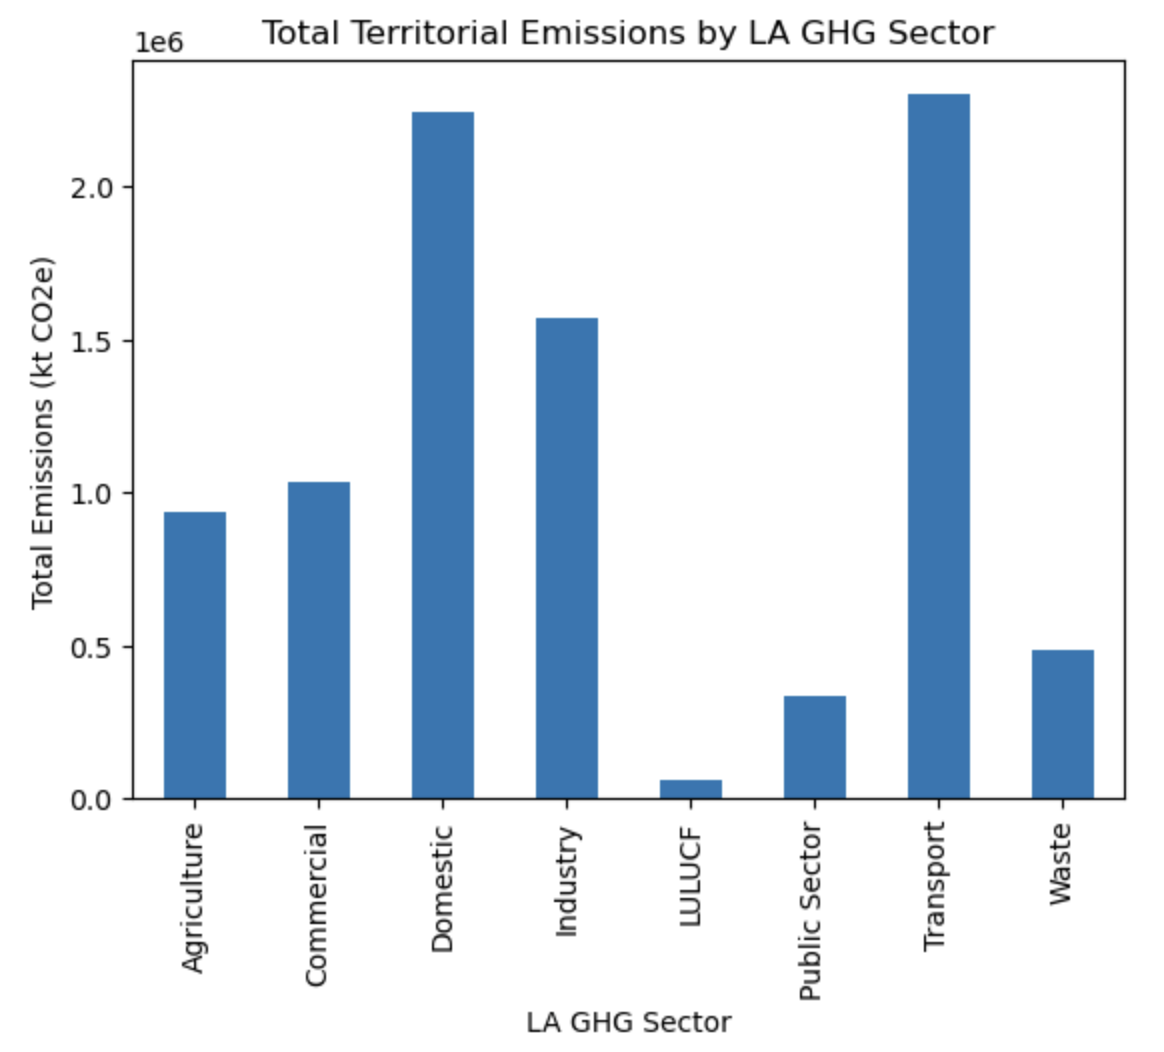
This bar chart highlights the contributions of various sectors to total emissions. The Domestic and Transport sectors emerge as dominant contributors, followed by Industry. In contrast, sectors like LULUCF and Public Sector show significantly lower emissions.

2. **Territorial Emissions by Greenhouse Gas**

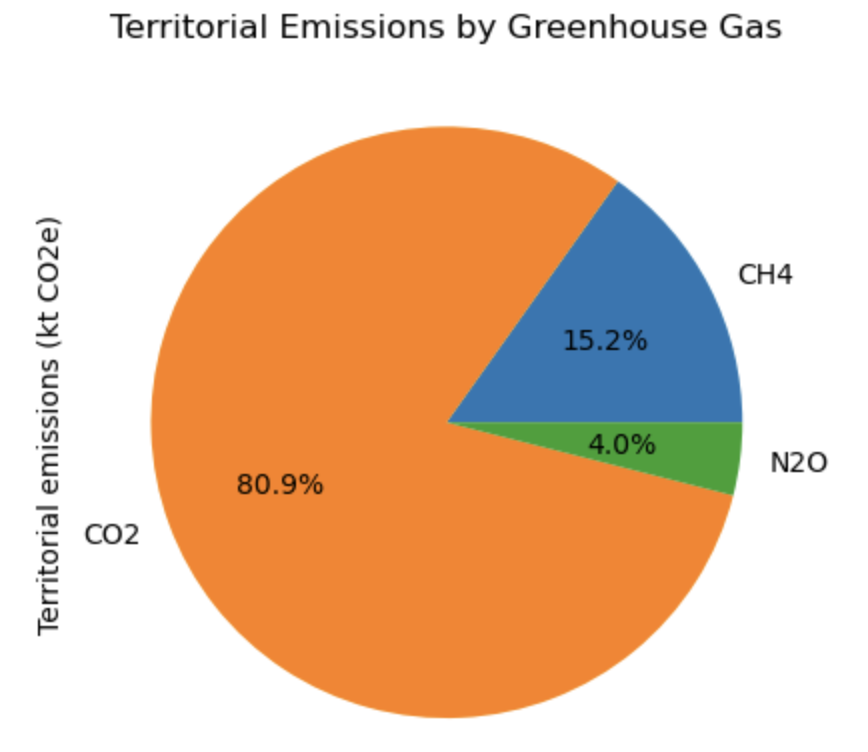
The pie chart demonstrates the dominance of CO2 emissions, accounting for 80.9% of total emissions. CH4 and N2O contribute 15.2% and 4.0%, respectively, illustrating the necessity of focusing on CO2 reductions for impactful mitigation.

4. **Territorial Emissions by Region**

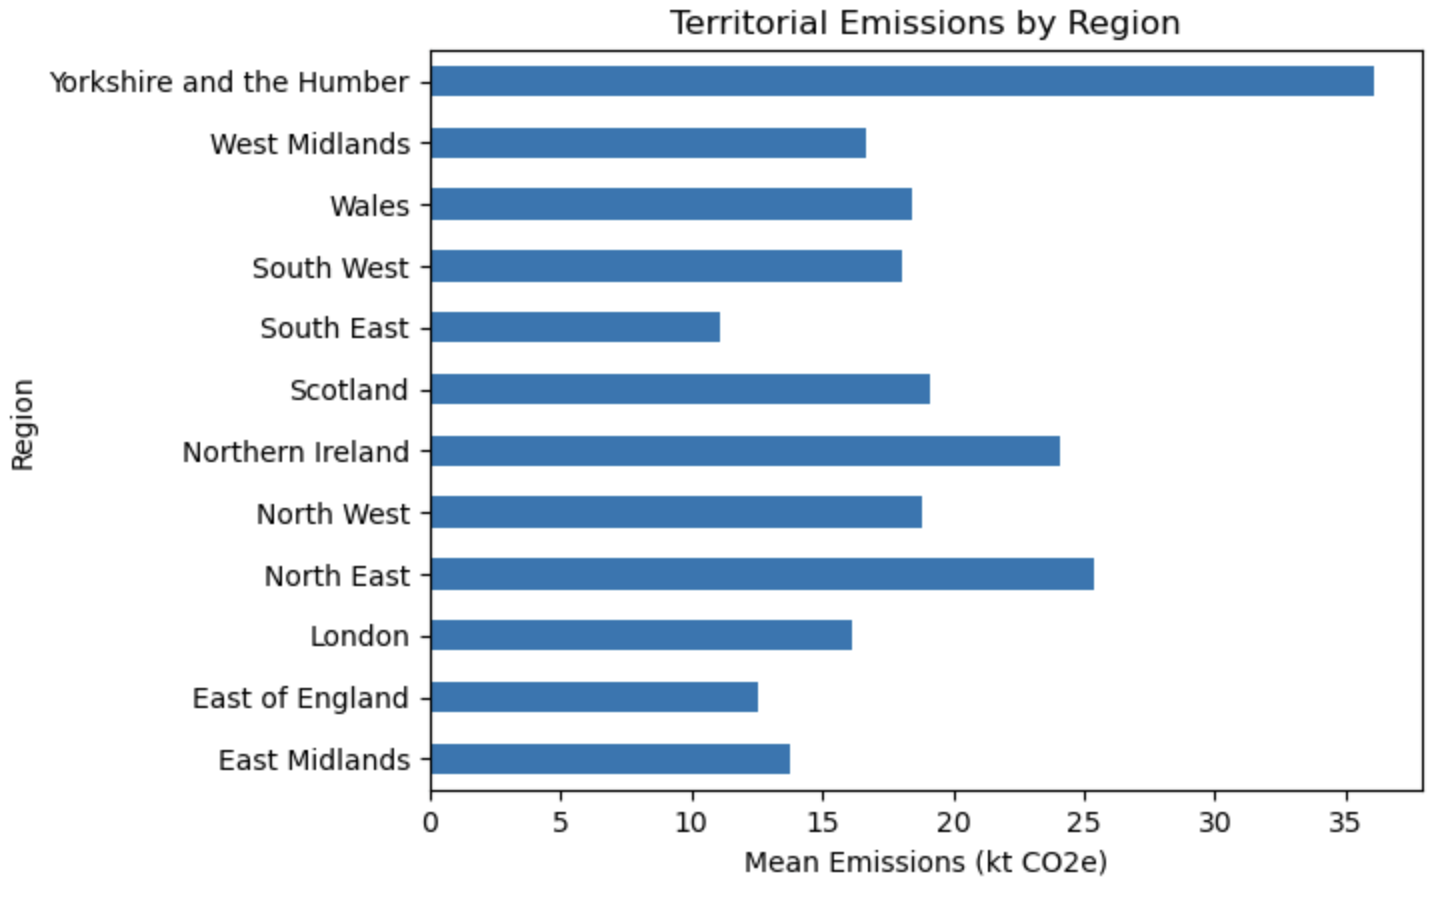
Regional analysis reveals significant variations, with Yorkshire and the Humber showing the highest emissions on average. Regions like East Midlands and East of England report comparatively lower emissions.

6. **Yearly Average Territorial Emissions**

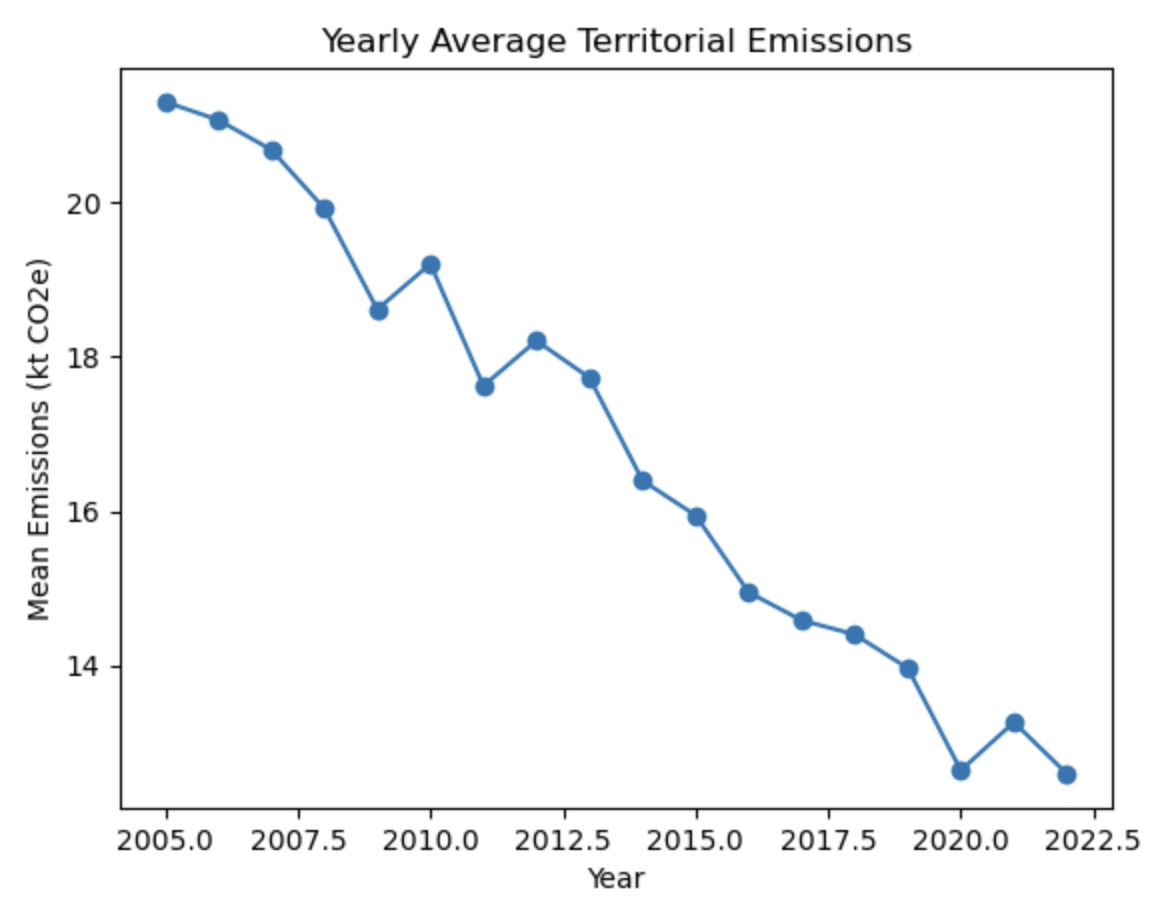
This line plot shows a clear declining trend in average emissions over time, reflecting positive progress toward emissions reduction goals. However, there are slight fluctuations, especially post-2020, likely due to external factors such as policy changes or global disruptions.

8. **Yearly Change Rate of Emissions by Sector**

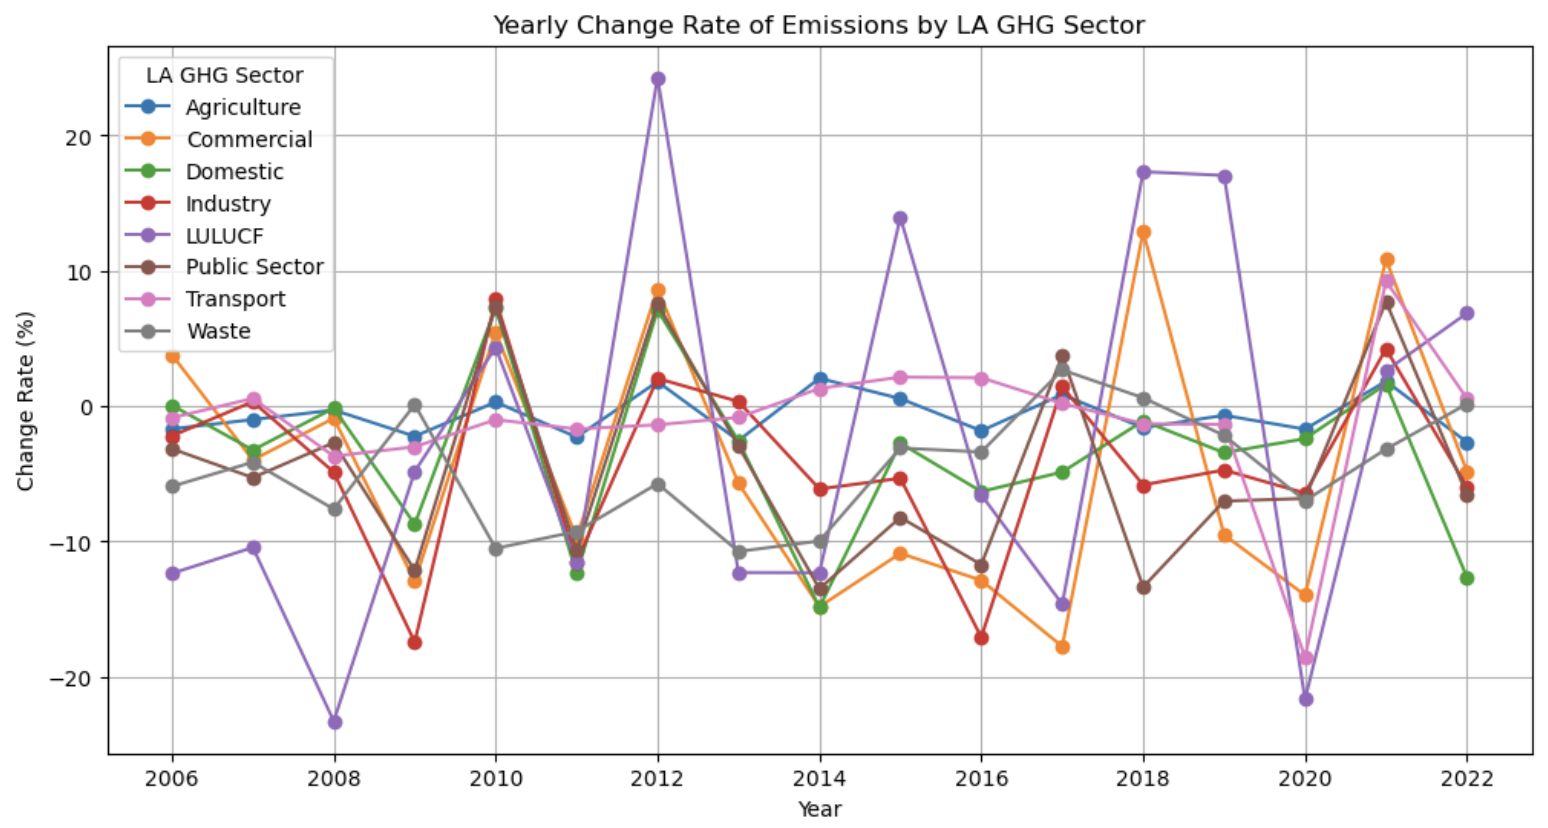
This dynamic visualization captures the sectoral year-on-year percentage change. Sectors like Transport and Industry exhibit higher volatility, while sectors like LULUCF show more dramatic peaks and troughs.

10. **Yearly Emission Changes by Region**

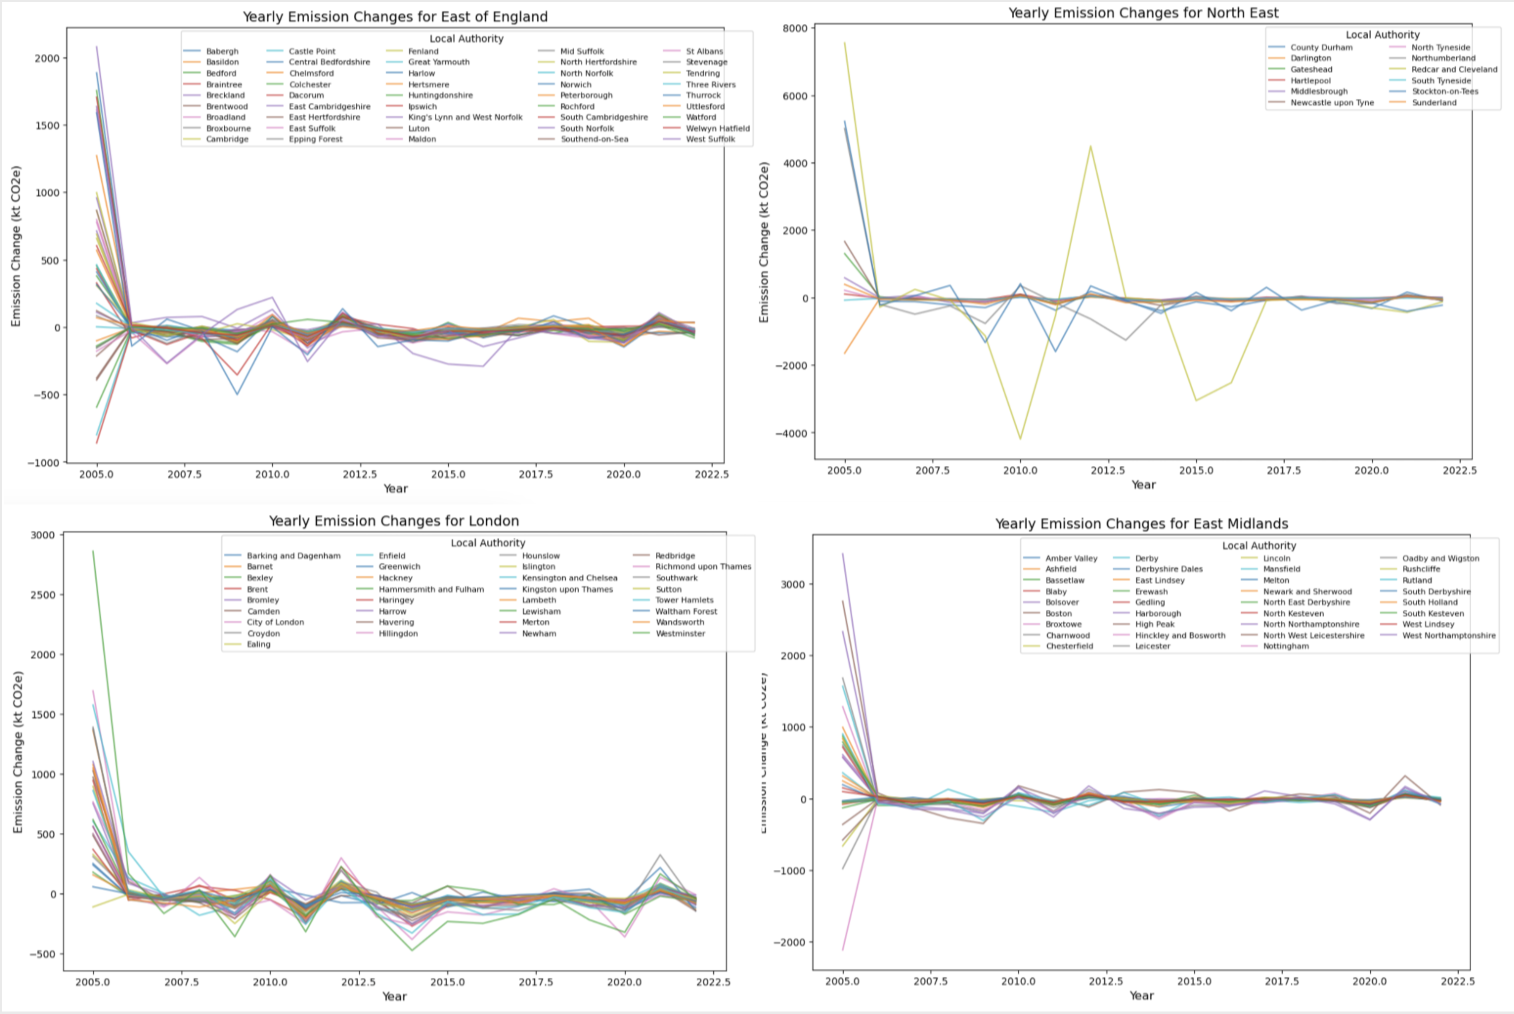
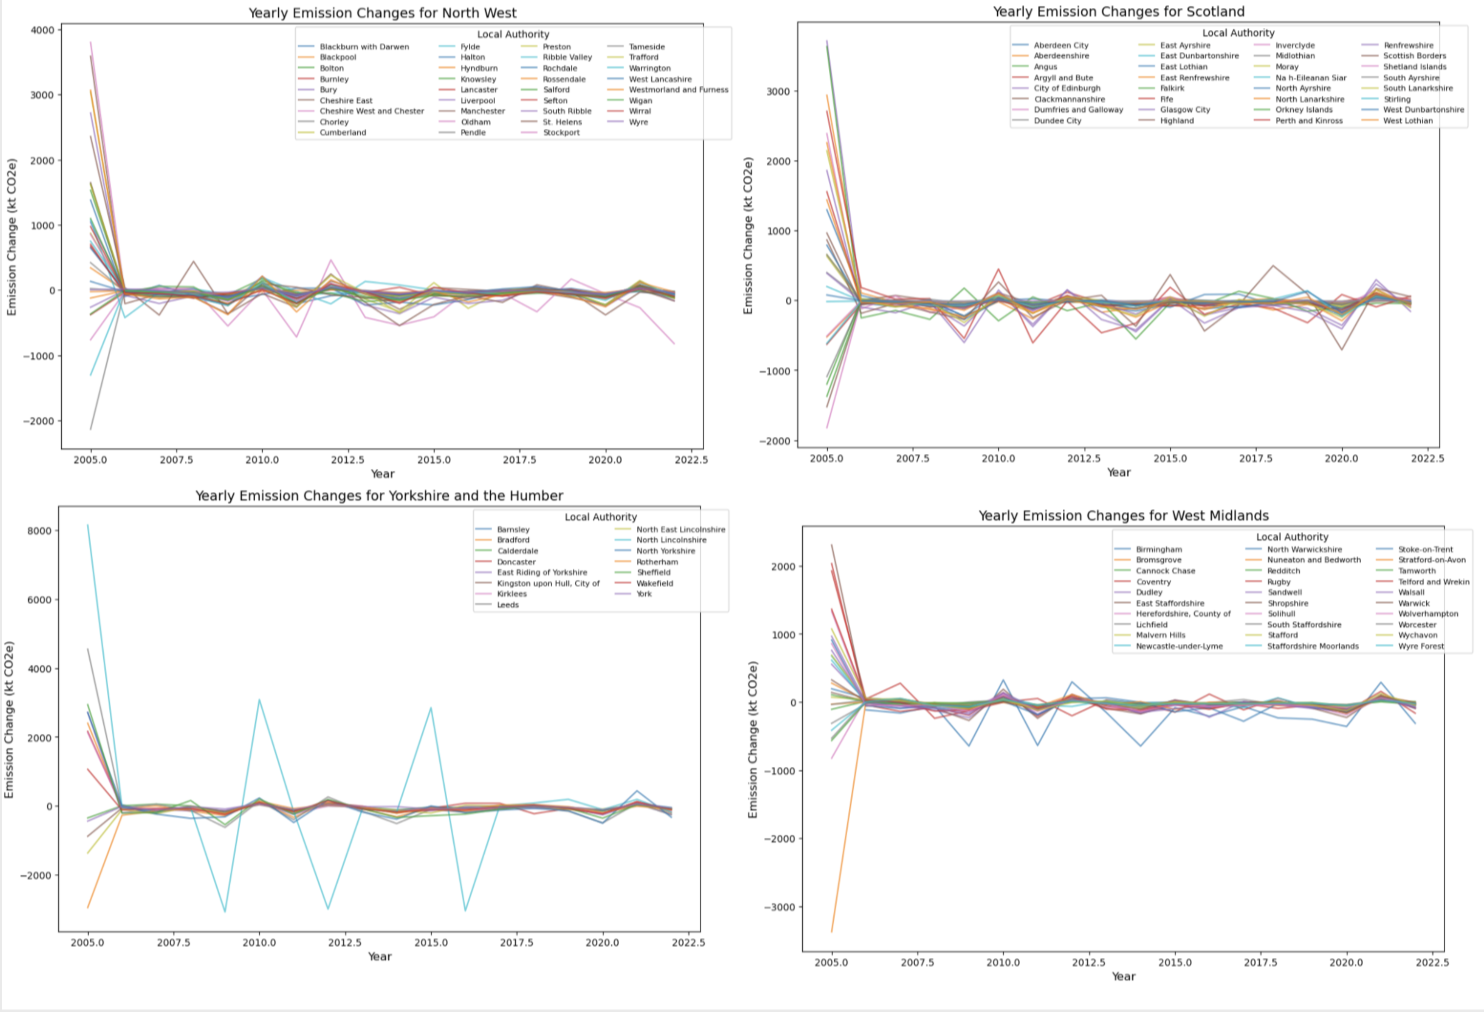
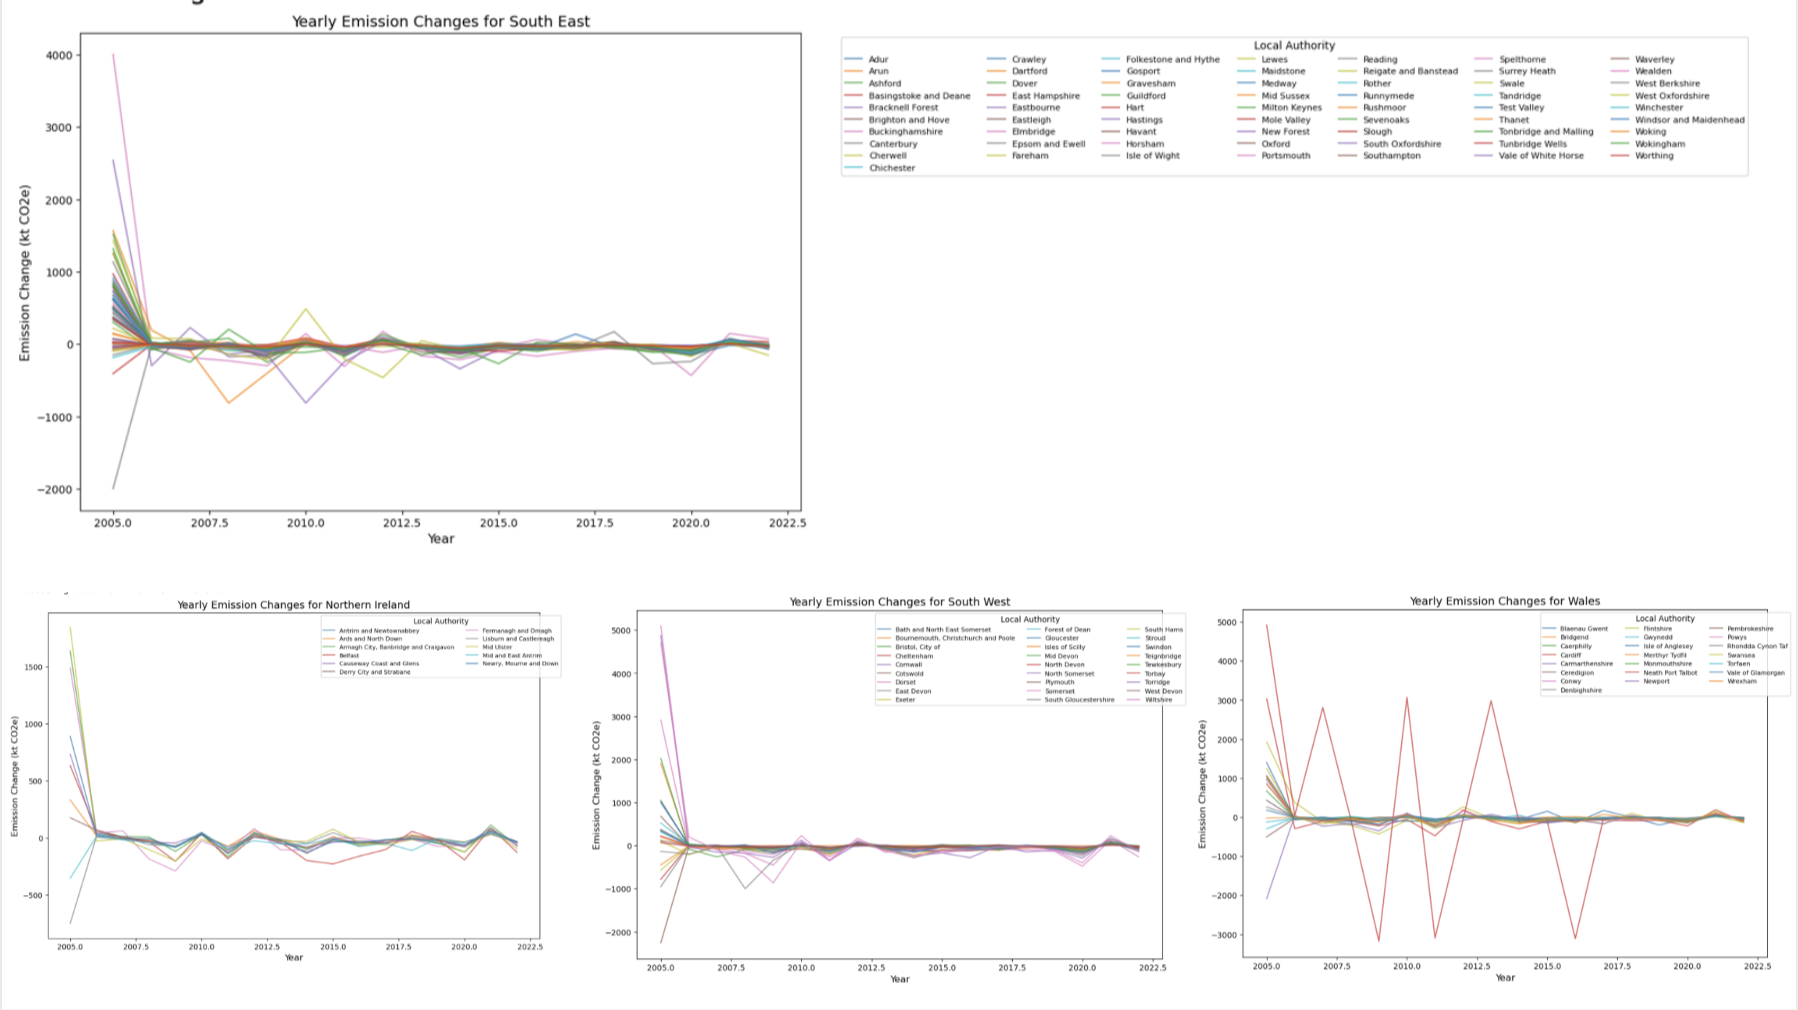
Each region's yearly emissions are plotted against time, revealing unique patterns across Local Authorities:
- Regions such as East of England, North East, and London show relatively stable trends post-2008, following initial fluctuations.
- Regions like Wales and Yorkshire and the Humber exhibit more dramatic peaks and variations, possibly linked to specific industries or policy implementations.
- The decline is consistent across all regions, with occasional outliers, emphasizing both regional challenges and collective progress.

## Conclusions and Recommendations

Based on the comprehensive data analysis conducted, several key findings and actionable recommendations can be summarized. Firstly, population density and emissions per area were identified as critical metrics for understanding regional variations in emissions. Urban areas like London exhibited high population densities and emissions per area, indicating significant energy consumption and urban activities, whereas rural regions such as Northern Ireland and Wales demonstrated lower values, reflecting limited industrialization and energy use.

Yorkshire and the Humber stood out with unexpectedly high territorial emissions compared to London, which was initially surprising. However, further analysis revealed that Yorkshire's vast area (approximately 1,046 km²) accounted for the higher emissions, despite London having greater efficiency in emissions per unit area.

The correlation analysis indicated weak or negligible relationships between emissions and factors like population density or area, suggesting that emissions are influenced more by industrial activities and energy consumption patterns rather than simple demographic or geographic variables. Furthermore, temporal trends showed a consistent decline in emissions over time, likely reflecting the impact of environmental policies and industrial shifts.

A deeper dive into specific LA GHG sectors uncovered significant variability, especially in sectors like Transport and LULUCF. These sectors exhibited sharp fluctuations in emissions changes, underscoring the need for targeted policy interventions such as improved energy efficiency in transportation and land management strategies. Conversely, relatively stable sectors like Domestic and Commercial offer opportunities for incremental technological improvements.

Policy recommendations emphasize the need for localized and sector-specific strategies. Urban regions require robust public transportation systems, renewable energy expansion, and energy-efficient infrastructure. For rural areas, careful monitoring of industrialization trends and proactive policy measures can prevent future emission increases. Lastly, further research incorporating additional datasets, such as economic trends and international policy shifts, is essential to understand the underlying causes of emission trends and improve long-term sustainability.

## Methodology Explanation and Documentation

The methodology for the analysis performed in this project utilises useful features of Python libraries such as NumPy and Pandas to efficiently manipulate, analyze, and visualize the dataset. Pandas was chosen for its robust DataFrame structure, which enabled seamless handling of tabular formatted data, including filtering, grouping, and aggregating emissions by various categories like region, greenhouse gas type, and LA GHG sector. NumPy was utilized for numerical computations, such as calculating statistical metrics like mean, standard deviation, and correlation coefficients. 

One of the challenges encountered during the analysis was dealing with negative emissions values, particularly in the LULUCF sector. This required careful consideration and additional analysis to interpret these values accurately as indicative of carbon absorption activities rather than errors. In this analysis, it was not treated to observe the cause of the negative value in the dataset but this would be considered dropping or handling differently if the purpose of the analysis is to only observing the general trend of the amount of the emissions or the final purpose of the dataset is to put it into artificial modelling in purpose of reducing noises. 

Another challenge was the large number of unique local authorities, which made visualizing emission changes across all of them difficult. To address this, the data was first grouped by countries and visualized separately for clearer representation. However, this still have problem with the authorities in England area, as they have relatively overwhelming number of local authorities comparing with other countries, resulting in the plot of England unclear. Therefore, it was finally grouped by regions to for clearer visualisation. Nonetheless, this causes numerious plots, which is a trade-off, and still have a number of local authority in South East region. This would be further resolved if the dataset that enables other upper hierarchy that can group up the local authority in more efficient way. 

- Guidance of future investigation and analysis related to this dataset

If further analysis is conducted in the future, several additional directions and datasets could significantly enhance the depth and accuracy of the findings. First, incorporating detailed economic datasets, such as regional GDP, employment rates, and industrial contributions, could help better understand the relationship between economic activity and emissions. Additionally, data on energy consumption patterns, including the share of renewable energy versus fossil fuels, would provide valuable insights into how energy sources influence emissions across regions.

Demographic data, such as population growth trends, urbanization rates, and household energy usage, could further refine the analysis by identifying specific population-driven factors affecting emissions. For sectors like LULUCF, satellite data on land use changes, reforestation efforts, and soil carbon sequestration could provide a more precise understanding of negative emissions and carbon absorption dynamics. Moreover, incorporating international policy data or event-based datasets, such as economic recessions, natural disasters, or major regulatory changes, could help identify causal factors behind sharp emission changes in certain years. Finally, a longitudinal comparison with datasets from other countries or regions could offer a broader perspective and help benchmark emissions trends against global standards.

## Reference

1. *data.gov.uk (2024) UK greenhouse gas emissions: local authority and regional. Available at: https://www.data.gov.uk/dataset/723c243d-2f1a-4d27-8b61-cdb93e5b10ff/uk-greenhouse-gas-emissions-local-authority-and-regional (Accessed: 4 December 2024).*
2. *United Nations (2017) Land Use, Land-Use Change and Forestry (LULUCF). UNFCCC. Available at: https://unfccc.int/topics/land-use/workstreams/land-use--land-use-change-and-forestry-lulucf (Accessed: 4 December 2024).*
3. *Our World in Data (n.d.) CO2 and Greenhouse Emissions Data Explorer. Available at: https://ourworldindata.org/explore (Accessed: 4 December 2024).*